In [ ]:
import pandas as pd
import numpy as np
import kaggle as kaggle
from IPython.display import clear_output
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import preprocessing, metrics
import gc
import joblib
import warnings
from typing import Union
from tqdm.auto import tqdm as tqdm
from multiprocessing import  Pool
from  datetime import datetime, timedelta

warnings.filterwarnings('ignore')

In [ ]:
INPUT_DIR_PATH = 'data/m5-forecasting-accuracy/'

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def read_data():
    sell_prices_df = pd.read_csv(INPUT_DIR_PATH + 'sell_prices.csv')
    sell_prices_df = reduce_mem_usage(sell_prices_df)
    print('Sell prices has {} rows and {} columns'.format(sell_prices_df.shape[0], sell_prices_df.shape[1]))

    calendar_df = pd.read_csv(INPUT_DIR_PATH + 'calendar.csv')
    calendar_df = reduce_mem_usage(calendar_df)
    print('Calendar has {} rows and {} columns'.format(calendar_df.shape[0], calendar_df.shape[1]))

    sales_train_validation_df = pd.read_csv(INPUT_DIR_PATH + 'sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation_df.shape[0], sales_train_validation_df.shape[1]))

    submission_df = pd.read_csv(INPUT_DIR_PATH + 'sample_submission.csv')
    return sell_prices_df, calendar_df, sales_train_validation_df, submission_df

In [ ]:
sell_prices_df, calendar_df, sales_train_validation_df, submission_df = read_data()

In [ ]:
NUM_ITEMS = sales_train_validation_df.shape[0]  # 30490
DAYS_PRED = 28
nrows = 365 * 2 * NUM_ITEMS

In [ ]:
class WRMSSEEvaluator(object):
    
    group_ids = ( 'all_id', 'state_id', 'store_id', 'cat_id', 'dept_id', 'item_id',
        ['state_id', 'cat_id'],  ['state_id', 'dept_id'], ['store_id', 'cat_id'],
        ['store_id', 'dept_id'], ['item_id', 'state_id'], ['item_id', 'store_id'])

    def __init__(self, 
                 train_df: pd.DataFrame, 
                 valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, 
                 prices: pd.DataFrame):
        '''
        intialize and calculate weights
        '''
        self.calendar = calendar
        self.prices = prices
        self.train_df = train_df
        self.valid_df = valid_df
        self.train_target_columns = [i for i in self.train_df.columns if i.startswith('d_')]
        self.weight_columns = self.train_df.iloc[:, -28:].columns.tolist()

        self.train_df['all_id'] = "all"

        self.id_columns = [i for i in self.train_df.columns if not i.startswith('d_')]
        self.valid_target_columns = [i for i in self.valid_df.columns if i.startswith('d_')]

        if not all([c in self.valid_df.columns for c in self.id_columns]):
            self.valid_df = pd.concat([self.train_df[self.id_columns], self.valid_df],
                                      axis=1, 
                                      sort=False)
        self.train_series = self.trans_30490_to_42840(self.train_df, 
                                                      self.train_target_columns, 
                                                      self.group_ids)
        self.valid_series = self.trans_30490_to_42840(self.valid_df, 
                                                      self.valid_target_columns, 
                                                      self.group_ids)
        self.weights = self.get_weight_df()
        self.scale = self.get_scale()
        self.train_series = None
        self.train_df = None
        self.prices = None
        self.calendar = None

    def get_scale(self):
        '''
        scaling factor for each series ignoring starting zeros
        '''
        scales = []
        for i in tqdm(range(len(self.train_series))):
            series = self.train_series.iloc[i].values
            series = series[np.argmax(series!=0):]
            scale = ((series[1:] - series[:-1]) ** 2).mean()
            scales.append(scale)
        return np.array(scales)
    
    def get_name(self, i):
        '''
        convert a str or list of strings to unique string 
        used for naming each of 42840 series
        '''
        if type(i) == str or type(i) == int:
            return str(i)
        else:
            return "--".join(i)
    
    def get_weight_df(self) -> pd.DataFrame:
        """
        returns weights for each of 42840 series in a dataFrame
        """
        day_to_week = self.calendar.set_index("d")["wm_yr_wk"].to_dict()
        weight_df = self.train_df[["item_id", "store_id"] + self.weight_columns].set_index(
            ["item_id", "store_id"]
        )
        weight_df = (
            weight_df.stack().reset_index().rename(columns={"level_2": "d", 0: "value"})
        )
        weight_df["wm_yr_wk"] = weight_df["d"].map(day_to_week)
        weight_df = weight_df.merge(
            self.prices, how="left", on=["item_id", "store_id", "wm_yr_wk"]
        )
        weight_df["value"] = weight_df["value"] * weight_df["sell_price"]
        weight_df = weight_df.set_index(["item_id", "store_id", "d"]).unstack(level=2)[
            "value"
        ]
        weight_df = weight_df.loc[
            zip(self.train_df.item_id, self.train_df.store_id), :
        ].reset_index(drop=True)
        weight_df = pd.concat(
            [self.train_df[self.id_columns], weight_df], axis=1, sort=False
        )
        weights_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False)):
            lv_weight = weight_df.groupby(group_id)[self.weight_columns].sum().sum(axis=1)
            lv_weight = lv_weight / lv_weight.sum()
            for i in range(len(lv_weight)):
                weights_map[self.get_name(lv_weight.index[i])] = np.array(
                    [lv_weight.iloc[i]]
                )
        weights = pd.DataFrame(weights_map).T / len(self.group_ids)

        return weights

    def trans_30490_to_42840(self, df, cols, group_ids, dis=False):
        '''
        transform 30490 sries to all 42840 series
        '''
        series_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False, disable=dis)):
            tr = df.groupby(group_id)[cols].sum()
            for i in range(len(tr)):
                series_map[self.get_name(tr.index[i])] = tr.iloc[i].values
        return pd.DataFrame(series_map).T
    
    def get_rmsse(self, valid_preds) -> pd.Series:
        '''
        returns rmsse scores for all 42840 series
        '''
        score = ((self.valid_series - valid_preds) ** 2).mean(axis=1)
        rmsse = (score / self.scale).map(np.sqrt)
        return rmsse

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds],
                                axis=1, 
                                sort=False)
        valid_preds = self.trans_30490_to_42840(valid_preds, 
                                                self.valid_target_columns, 
                                                self.group_ids, 
                                                True)
        self.rmsse = self.get_rmsse(valid_preds)
        self.contributors = pd.concat([self.weights, self.rmsse], 
                                      axis=1, 
                                      sort=False).prod(axis=1)
        return np.sum(self.contributors)

In [ ]:
train_fold_df = sales_train_validation_df.iloc[:, :-28]
valid_fold_df = sales_train_validation_df.iloc[:, -28:].copy()

wrmsse_e = WRMSSEEvaluator(train_fold_df, valid_fold_df, calendar_df, sell_prices_df)
del train_fold_df, valid_fold_df
gc.collect()

In [ ]:
def encode_categorical(df, cols):
    for col in cols:
        # Leave NaN as it is.
        le = preprocessing.LabelEncoder()
        not_null = df[col][df[col].notnull()]
        df[col] = pd.Series(le.fit_transform(not_null), index=not_null.index)

    return df


calendar_df = encode_categorical(calendar_df, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]).pipe(reduce_mem_usage)
sales_train_validation_df = encode_categorical(sales_train_validation_df, ["item_id", "dept_id", "cat_id", "store_id", "state_id"]).pipe(reduce_mem_usage)
sell_prices_df = encode_categorical(sell_prices_df, ["item_id", "store_id"]).pipe(reduce_mem_usage)

In [ ]:
# function to read the data and merge it

def melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 55000000, merge = False):
    
    # melt sales data, get it ready for training
    sales_train_validation = pd.melt(sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    print('Melted sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    
    sales_train_validation = sales_train_validation.iloc[-nrows:,:]
    
    
    # seperate test dataframes
    test1_rows = [row for row in submission['id'] if 'validation' in row]
    test2_rows = [row for row in submission['id'] if 'evaluation' in row]
    test1 = submission[submission['id'].isin(test1_rows)]
    test2 = submission[submission['id'].isin(test2_rows)]
    
    # change column names
    test1.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 'd_1931', 
                      'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939', 'd_1940', 'd_1941']
    test2.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959', 
                      'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']
    
    # get product table
    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
    
    # merge with product table
    test2['id'] = test2['id'].str.replace('_evaluation','_validation')
    test1 = test1.merge(product, how = 'left', on = 'id')
    test2 = test2.merge(product, how = 'left', on = 'id')
    test2['id'] = test2['id'].str.replace('_validation','_evaluation')
    
    # 
    test1 = pd.melt(test1, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    test2 = pd.melt(test2, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    
    sales_train_validation['part'] = 'train'
    test1['part'] = 'test1'
    test2['part'] = 'test2'
    
    data = pd.concat([sales_train_validation, test1, test2], axis = 0)
    
    del sales_train_validation, test1, test2
    
    print(data.shape)
    
    # get only a sample for fst training
#     data = data.loc[nrows:]
    
    # drop some calendar features
    calendar.drop(['weekday', 'wday', 'month', 'year'], inplace = True, axis = 1)
    
    # delete test2 for now
    data = data[data['part'] != 'test2']
    
    if merge:
        # notebook crash with the entire dataset (maybee use tensorflow, dask, pyspark xD)
        data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
        data.drop(['d', 'day'], inplace = True, axis = 1)
        # get the sell price data (this feature should be very important)
        data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
        print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
    else: 
        pass
    
    gc.collect()
    
    return data

In [ ]:
# nrows = 365 * 2 * NUM_ITEMS
data = melt_and_merge(calendar_df, sell_prices_df, sales_train_validation_df, submission_df, nrows = nrows, merge = True)

In [ ]:
def transform(data):
    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)
        
    cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    return data

def simple_fe(data):
    
    # rolling demand features
    
    for val in [28, 29, 30]:
        data[f"shift_t{val}"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(val))
    for val in [7, 30, 60, 90, 180]:
        data[f"rolling_std_t{val}"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(28).rolling(val).std())
    for val in [7, 30, 60, 90, 180]:
        data[f"rolling_mean_t{val}"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(28).rolling(val).mean())

    data["rolling_skew_t30"] = data.groupby(["id"])["demand"].transform( lambda x: x.shift(28).rolling(30).skew())
    data["rolling_kurt_t30"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(28).rolling(30).kurt())
    
    # price features
    data['lag_price_t1'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1))
    data['price_change_t1'] = (data['lag_price_t1'] - data['sell_price']) / (data['lag_price_t1'])
    data['rolling_price_max_t365'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(365).max())
    data['price_change_t365'] = (data['rolling_price_max_t365'] - data['sell_price']) / (data['rolling_price_max_t365'])
    data['rolling_price_std_t7'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
    data['rolling_price_std_t30'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
    data.drop(['rolling_price_max_t365', 'lag_price_t1'], inplace = True, axis = 1)
    
#     # time features
    data['date'] = pd.to_datetime(data['date'])
    attrs = ["year", "quarter", "month", "week", "day", "dayofweek", "is_year_end", "is_year_start", "is_quarter_end", \
        "is_quarter_start", "is_month_end","is_month_start",
    ]

    for attr in attrs:
        dtype = np.int16 if attr == "year" else np.int8
        data[attr] = getattr(data['date'].dt, attr).astype(dtype)
    data["is_weekend"] = data["dayofweek"].isin([5, 6]).astype(np.int8)
    
    return data

In [ ]:
features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
    # demand features.
    "shift_t28",
    "rolling_std_t7",
    "rolling_std_t30",
    "rolling_std_t90",
    "rolling_std_t180",
    "rolling_mean_t7",
    "rolling_mean_t30",
    "rolling_mean_t60",
    # price features
    "price_change_t1",
    "price_change_t365",
    "rolling_price_std_t7",
    # time features.
    "year",
    "month",
    "dayofweek",
]

In [89]:
def train_lgb(data):
    
    # going to evaluate with the last 28 days
    x_train = data[data['date'] <= '2016-03-27']
    y_train = x_train['demand']
    x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
    y_val = x_val['demand']
#     del data
    gc.collect()
    
    params = {
        'boosting_type': 'gbdt',
        'metric': 'custom',
        'objective': 'poisson',
        'n_jobs': -1,
        "force_row_wise" : True,
        "learning_rate" : 0.075,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        'verbosity': 1,
        'num_iterations' : 450,
    }

    train_set = lgb.Dataset(x_train[features], y_train)
    val_set = lgb.Dataset(x_val[features], y_val)
    
    del x_train, y_train
    
    
    model = lgb.train(
        params,
        train_set,
        valid_sets = [val_set],
        verbose_eval = 50,
#       fobj = custom_asymmetric_train,
        feval = wrmsse
    )
    
    joblib.dump(model, 'lgbm_0.sav')
    
    val_pred = model.predict(x_val[features], num_iteration=model.best_iteration)
    val_score = wrmsse(val_pred, data)
    print(f'Our val wrmse score is {val_score}')
    return model

In [ ]:
def prediction(model, data):
    print('Predict...')
    %time
    prediction = data[(data['date'] > '2016-04-24')]
    y_pred = model.predict(prediction[features], num_iteration=model.best_iteration)
    prediction['demand'] = y_pred
    print('Prediction ready')
    return prediction

In [ ]:
# custome objective function

def custom_asymmetric_train(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2 * residual, -2 * residual * 1.15)
    hess = np.where(residual < 0, 2, 2 * 1.15)
    return grad, hess

In [ ]:
# custome validation function

def wrmsse(preds, train_data):
    revert_data = data[['id', 'date', 'demand']]
    revert_data = revert_data[-(NUM_ITEMS * DAYS_PRED):]
    revert_data['demand'] = preds
    revert_data = pd.pivot(revert_data, index = 'id', columns = 'date', values = 'demand').reset_index()
    revert_data = submission_df[['id']].merge(revert_data, on = 'id')
    revert_data.columns = ['id'] + ['d_' + str(1886 + i) for i in range(28)]
    revert_data.drop(['id'], axis=1, inplace = True)
    score = wrmsse_e.score(revert_data)
    print('wrmsse score: ', score)
    
    del revert_data
    gc.collect()
    
    return 'wrmsse', score, False

In [ ]:
def generate_submition(test, submission):
    predictions = test[['id', 'date', 'demand']]
    predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
    evaluation = submission[submission['id'].isin(evaluation_rows)]

    validation = submission[['id']].merge(predictions, on = 'id')
    final = pd.concat([validation, evaluation])
    final.to_csv('submission.csv', index = False)

In [105]:
def prediction_dbd(model, data):
    max_lags = 366
    h = 28
    fday = datetime(2016,4, 25)
    for i in range(0, 28):
        day = fday + timedelta(days=i)
        print(i, day)
        tst = data[(data.date >= day - timedelta(days=max_lags)) & (data.date <= day)].copy()
        tst = tst.loc[tst.date == day , features]
        data.loc[data.date == day, "sales"] = 1*model.predict(tst) # magic multiplier by kyakovlev
        
        data_sub = data.loc[data.date >= fday, ["id", "sales"]].copy()
        data_sub.loc[data.date >= fday+ timedelta(days=h), "id"] = data_sub.loc[data.date >= fday+timedelta(days=h),"id"].str.replace("validation$", "evaluation")
        data_sub["F"] = [f"F{rank}" for rank in data_sub.groupby("id")["id"].cumcount()+1]
        data_sub = data_sub.set_index(["id", "F" ]).unstack()["sales"][[f"F{i}" for i in range(1,29)]].reset_index()
        data_sub.fillna(0., inplace = True)
        
        data_sub = submission_df[['id']].merge(data_sub, on = 'id')

    return data, data_sub

In [ ]:
data = simple_fe(data)
data = reduce_mem_usage(data)

In [ ]:
model = train_lgb(data)

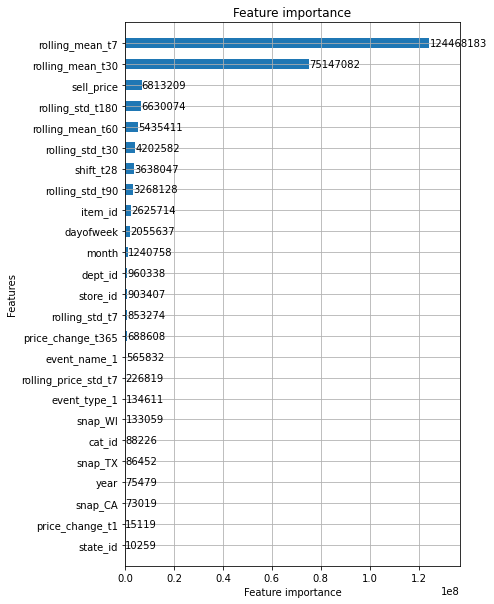

In [91]:
def futures_importance(model):
    lgb.plot_importance(model, importance_type="gain", precision=0, height=0.5, figsize=(6, 10));
    return
futures_importance(model)

In [92]:
predicted_values = prediction(model, data)

Predict...
Wall time: 0 ns
Prediction ready


In [106]:
# predict day-by-day
predicted_values_dbd, predicted_values_sub = prediction_dbd(model, data)

evaluation_rows = [row for row in submission_df['id'] if 'evaluation' in row] 
evaluation = submission_df[submission_df['id'].isin(evaluation_rows)]
final_d = pd.concat([predicted_values_sub, evaluation])
final_d.to_csv('submission_d.csv', index = False)
    
predicted_values_sub.drop('id', axis=1, inplace=True)
predicted_values_sub.columns =['d_' + str(1886 + i) for i in range(28)]
print('day-to-day wrmsse: ',wrmsse_e.score(predicted_values_sub))

0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00
day-to-day wrmsse:  0.5995098707763498


In [96]:
generate_submition(predicted_values, submission_df)

In [107]:
# !kaggle competitions submit m5-forecasting-accuracy -f submission_d.csv -m "first local submition"
# !kaggle competitions submissions m5-forecasting-accuracy

Successfully submitted to M5 Forecasting - Accuracy



  0%|          | 0.00/20.6M [00:00<?, ?B/s]
  0%|          | 80.0k/20.6M [00:00<00:26, 802kB/s]
  7%|7         | 1.53M/20.6M [00:00<00:17, 1.12MB/s]
 11%|#         | 2.20M/20.6M [00:00<00:12, 1.50MB/s]
 13%|#3        | 2.72M/20.6M [00:01<00:18, 988kB/s] 
 18%|#8        | 3.71M/20.6M [00:01<00:13, 1.36MB/s]
 21%|##1       | 4.40M/20.6M [00:01<00:09, 1.79MB/s]
 25%|##4       | 5.08M/20.6M [00:01<00:07, 2.31MB/s]
 28%|##8       | 5.77M/20.6M [00:01<00:05, 2.90MB/s]
 31%|###1      | 6.45M/20.6M [00:01<00:04, 3.53MB/s]
 35%|###4      | 7.15M/20.6M [00:01<00:03, 4.18MB/s]
 38%|###8      | 7.83M/20.6M [00:01<00:02, 4.76MB/s]
 46%|####6     | 9.54M/20.6M [00:02<00:01, 6.10MB/s]
 51%|#####1    | 10.5M/20.6M [00:02<00:01, 6.39MB/s]
 55%|#####5    | 11.4M/20.6M [00:02<00:01, 6.62MB/s]
 60%|#####9    | 12.2M/20.6M [00:02<00:01, 6.75MB/s]
 63%|######3   | 13.0M/20.6M [00:02<00:01, 6.93MB/s]
 67%|######7   | 13.8M/20.6M [00:02<00:01, 6.98MB/s]
 71%|#######   | 14.5M/20.6M [00:02<00:00, 7.06MB/s]
 7